# MobileNetV2 Plant Disease Classification

This notebook trains a MobileNetV2 model for plant disease classification using our modular source code.

## 1. Setup and Imports

In [1]:
# Add workspace root to Python path so we can import src module
import sys
import os

# Get the current working directory (
root_dir = os.getcwd()

# Verify and add to path
if os.path.exists(os.path.join(root_dir, 'src')):
    if root_dir not in sys.path:
        sys.path.insert(0, root_dir)
    print(f"Adding {root_dir} to Python path")
else:
    # Try parent directory
    root_dir = os.path.dirname(root_dir)
    if os.path.exists(os.path.join(root_dir, 'src')):
        if root_dir not in sys.path:
            sys.path.insert(0, root_dir)
        print(f"Adding {root_dir} to Python path")
    else:
        print(f"Could not find src directory")

Adding d:\plant-disease-detection-using-cnns to Python path


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import from src modules
from src.config import TRAIN_DIR, VAL_DIR, MOBILENET_MODEL_SAVE_PATH, MOBILENET_NUM_EPOCHS
from src.utils import (
    load_datasets, get_class_distribution, identify_rare_classes,
    create_weighted_sampler, prepare_datasets, create_dataloaders,
    print_dataset_info, print_class_distribution, print_rare_classes,
    print_directory_counts
)
from src.models import get_mobilenet_model
from src.train import setup_training_mobilenet, train_model
from src.evaluate import evaluate
from src.transforms import get_val_transform
print("All imports successful!")

All imports successful!


## 2. Device Configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 3. Load Datasets

In [4]:
train_dataset_base, val_dataset_base, classes, num_classes = load_datasets()
print_dataset_info(classes, train_dataset_base, val_dataset_base)

Classes: ['citrus_black_spot', 'citrus_canker', 'citrus_foliage_damage', 'citrus_greening', 'citrus_healthy', 'citrus_mealybugs', 'citrus_melanose', 'mango_anthracnose', 'mango_bacterial_canker', 'mango_cutting_weevil', 'mango_die_back', 'mango_gall_midge', 'mango_healthy', 'mango_powdery_mildew', 'mango_sooty_mould']
Number of training images: 24499
Number of validation images: 6127


## 4. Analyze Class Distribution

In [5]:
class_counts, train_labels = get_class_distribution(train_dataset_base)
print_class_distribution(classes, class_counts)


Training class distribution:
citrus_black_spot                  : 136
citrus_canker                      : 8998
citrus_foliage_damage              : 1680
citrus_greening                    : 163
citrus_healthy                     : 5107
citrus_mealybugs                   : 3135
citrus_melanose                    : 2080
mango_anthracnose                  : 400
mango_bacterial_canker             : 400
mango_cutting_weevil               : 400
mango_die_back                     : 400
mango_gall_midge                   : 400
mango_healthy                      : 400
mango_powdery_mildew               : 400
mango_sooty_mould                  : 400


## 5. Identify Rare Classes

In [6]:
rare_classes = identify_rare_classes(class_counts)
print_rare_classes(classes, rare_classes)


Rare classes (< 200 samples):
citrus_black_spot
citrus_greening


## 6. Create Weighted Sampler

In [7]:
sampler = create_weighted_sampler(class_counts, train_labels, num_classes)
print("Weighted sampler created for balanced training")

Weighted sampler created for balanced training


## 7. Prepare Datasets with Transforms

In [8]:
train_dataset, val_dataset = prepare_datasets(
    train_dataset_base, val_dataset_base, rare_classes
)
print("Datasets prepared with class-aware augmentation")

Datasets prepared with class-aware augmentation


## 8. Create DataLoaders

In [9]:
train_loader, val_loader = create_dataloaders(train_dataset, val_dataset, sampler)
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Train batches: 383
Validation batches: 96


## 9. Create MobileNetV2 Model

In [10]:
model = get_mobilenet_model(num_classes, version='v2', dropout=0.2).to(device)
print("MobileNetV2 model created with pretrained ImageNet weights")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

MobileNetV2 model created with pretrained ImageNet weights
Total parameters: 2,243,087
Trainable parameters: 19,215


## 10. Setup Training

In [11]:
criterion, optimizer = setup_training_mobilenet(model, train_labels, num_classes, device)
print("Loss function: CrossEntropyLoss with class weights")
print("Optimizer: Adam with differential learning rates")
print("  - Classifier (head): 1e-3")
print("  - Last feature block: 1e-4")

Loss function: CrossEntropyLoss with class weights
Optimizer: Adam with differential learning rates
  - Classifier (head): 1e-3
  - Last feature block: 1e-4


## 11. Train Model

In [12]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=MOBILENET_NUM_EPOCHS,
    model_save_path=MOBILENET_MODEL_SAVE_PATH
)

Epoch 1/10 | Train Loss: 0.3806 | Train Acc: 0.8495 | Val Loss: 0.3571 | Val Acc: 0.8818
Epoch 2/10 | Train Loss: 0.1848 | Train Acc: 0.9424 | Val Loss: 0.1737 | Val Acc: 0.9350
Epoch 3/10 | Train Loss: 0.1574 | Train Acc: 0.9472 | Val Loss: 0.1606 | Val Acc: 0.9393
Epoch 4/10 | Train Loss: 0.1421 | Train Acc: 0.9528 | Val Loss: 0.1317 | Val Acc: 0.9492
Epoch 5/10 | Train Loss: 0.1429 | Train Acc: 0.9540 | Val Loss: 0.1165 | Val Acc: 0.9515
Epoch 6/10 | Train Loss: 0.1433 | Train Acc: 0.9517 | Val Loss: 0.2088 | Val Acc: 0.9130
EarlyStopping counter: 1/5
Epoch 7/10 | Train Loss: 0.1459 | Train Acc: 0.9532 | Val Loss: 0.1819 | Val Acc: 0.9306
EarlyStopping counter: 2/5
Epoch 8/10 | Train Loss: 0.1337 | Train Acc: 0.9559 | Val Loss: 0.1706 | Val Acc: 0.9282
EarlyStopping counter: 3/5
Epoch 9/10 | Train Loss: 0.1374 | Train Acc: 0.9576 | Val Loss: 0.1473 | Val Acc: 0.9365
EarlyStopping counter: 4/5
Epoch 10/10 | Train Loss: 0.1322 | Train Acc: 0.9562 | Val Loss: 0.1258 | Val Acc: 0.9465
E

## 12. Plot Training History

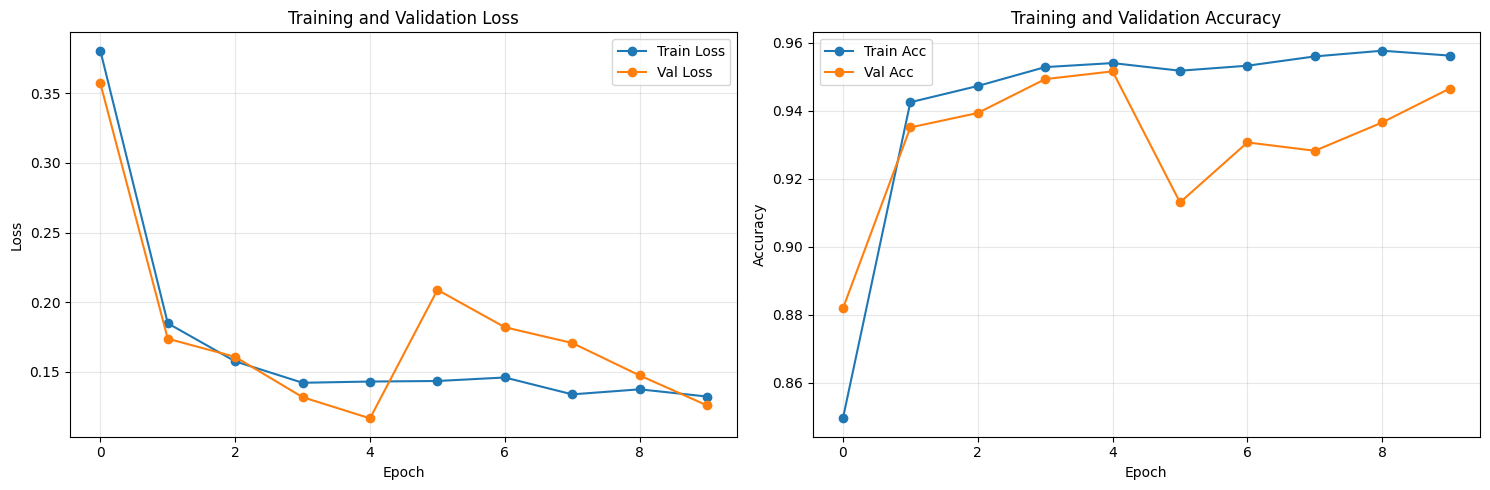


Best Validation Accuracy: 0.9515


In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(history['train_losses'], label='Train Loss', marker='o')
ax1.plot(history['val_losses'], label='Val Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(history['train_accs'], label='Train Acc', marker='o')
ax2.plot(history['val_accs'], label='Val Acc', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Validation Accuracy: {history['best_val_acc']:.4f}")

## 13. Final Evaluation

In [14]:
# Load best model
model.load_state_dict(torch.load(MOBILENET_MODEL_SAVE_PATH))
print("Loaded best model for evaluation\n")


# Evaluate on validation set
y_true, y_pred = evaluate(model, val_loader, device)

Loaded best model for evaluation


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84        35
           1       1.00      0.95      0.97      2250
           2       0.78      0.86      0.82       420
           3       0.85      0.95      0.90        41
           4       0.92      1.00      0.95      1277
           5       0.92      0.87      0.89       784
           6       1.00      1.00      1.00       520
           7       1.00      0.99      0.99       100
           8       1.00      1.00      1.00       100
           9       1.00      1.00      1.00       100
          10       0.97      1.00      0.99       100
          11       0.98      0.99      0.99       100
          12       1.00      1.00      1.00       100
          13       0.99      0.99      0.99       100
          14       0.99      0.98      0.98       100

    accuracy                           0.95      6127
   macro avg       0.9

## 14. Per-Class Accuracy Analysis

In [15]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Calculate per-class accuracy
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# Create DataFrame for better visualization
acc_df = pd.DataFrame({
    'Class': classes,
    'Accuracy': per_class_acc,
    'Samples': [class_counts[i] for i in range(num_classes)]
})
acc_df = acc_df.sort_values('Accuracy', ascending=False)

print("\nPer-Class Accuracy:")
print(acc_df.to_string(index=False))

print(f"\nMean Accuracy: {per_class_acc.mean():.4f}")
print(f"Std Accuracy: {per_class_acc.std():.4f}")


Per-Class Accuracy:
                 Class  Accuracy  Samples
       citrus_melanose  1.000000     2080
  mango_cutting_weevil  1.000000      400
mango_bacterial_canker  1.000000      400
         mango_healthy  1.000000      400
        mango_die_back  1.000000      400
        citrus_healthy  0.996085     5107
     mango_anthracnose  0.990000      400
  mango_powdery_mildew  0.990000      400
      mango_gall_midge  0.990000      400
     mango_sooty_mould  0.980000      400
       citrus_greening  0.951220      163
         citrus_canker  0.948000     8998
      citrus_mealybugs  0.868622     3135
 citrus_foliage_damage  0.864286     1680
     citrus_black_spot  0.771429      136

Mean Accuracy: 0.9566
Std Accuracy: 0.0661


# 15. Inference Pipeline

In [43]:
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

In [18]:
model.eval()
confidences = []

with torch.no_grad():
    for i in range(100):
        img_tensor, label = val_test[i]
        logits = model(img_tensor.unsqueeze(0).to(device))
        probs = F.softmax(logits, dim=1)
        conf, pred = torch.max(probs, dim=1)
        
        confidences.append(conf.item())

print(f"Average confidence: {np.mean(confidences):.2%}")
print(f"Min confidence: {np.min(confidences):.2%}")
print(f"Max confidence: {np.max(confidences):.2%}")

Average confidence: 92.46%
Min confidence: 38.87%
Max confidence: 99.99%


Inference on Validation Photo

In [19]:
from PIL import Image

val_transform = get_val_transform()
img = Image.open(r"C:\Users\loaim\OneDrive\Desktop\IMG_20211108_120942 (Custom).jpg").convert("RGB")
img_tensor = val_transform(img)

with torch.no_grad():
    model.eval()
    logits = model(img_tensor.unsqueeze(0).to(device))
    probs = F.softmax(logits, dim=1)
    conf, pred = torch.max(probs, dim=1)

print(f"Prediction: {classes[pred.item()]}")
print(f"Confidence: {conf.item():.2%}")

Prediction: mango_sooty_mould
Confidence: 100.00%


In [20]:
torch.save({
    "model_state": model.state_dict(),
    "class_to_idx": train_dataset.base_dataset.class_to_idx,
    "idx_to_class": classes,
}, MOBILENET_MODEL_SAVE_PATH)

print(f"✓ Model saved to {MOBILENET_MODEL_SAVE_PATH}")

✓ Model saved to ../models/MobileNet_model.pth


## Validation on Real-world Image

In [22]:
from PIL import Image

# Load model
ckpt = torch.load(MOBILENET_MODEL_SAVE_PATH, map_location=device)
model = get_mobilenet_model(len(classes), version='v2', dropout=0.2).to(device)
model.load_state_dict(ckpt["model_state"])
model.eval()

# Predict
img = Image.open(r"C:\Users\loaim\OneDrive\Desktop\img2.jpeg").convert("RGB")
img_tensor = get_val_transform()(img)

with torch.no_grad():
    logits = model(img_tensor.unsqueeze(0).to(device))
    probs = F.softmax(logits, dim=1)
    conf, pred = torch.max(probs, dim=1)

print(f"{classes[pred.item()]}: {conf.item():.2%}")

citrus_melanose: 72.13%


In [42]:

# Predict
img = Image.open(r"C:\Users\loaim\OneDrive\Desktop\furtBovAv5YwEs53CCKHeC.jpg").convert("RGB")
img_tensor = get_val_transform()(img)

with torch.no_grad():
    logits = model(img_tensor.unsqueeze(0).to(device))
    probs = F.softmax(logits, dim=1)
    conf, pred = torch.max(probs, dim=1)

print(f"{classes[pred.item()]}: {conf.item():.2%}")

citrus_melanose: 99.95%


In [ ]:

img = Image.open(r"C:\Users\loaim\OneDrive\Desktop\mango_powdery_mildew.jpg").convert("RGB")
img_tensor = get_val_transform()(img)

with torch.no_grad():
    logits = model(img_tensor.unsqueeze(0).to(device))
    probs = F.softmax(logits, dim=1)
    conf, pred = torch.max(probs, dim=1)

print(f"{classes[pred.item()]}: {conf.item():.2%}")

mango_powdery_mildew: 84.93%


In [ ]:
img = Image.open(r"C:\Users\loaim\OneDrive\Desktop\WhatsApp Image 2026-02-13 at 6.10.31 PM.jpeg").convert("RGB")
img_tensor = get_val_transform()(img)

with torch.no_grad():
    logits = model(img_tensor.unsqueeze(0).to(device))
    probs = F.softmax(logits, dim=1)
    conf, pred = torch.max(probs, dim=1)

print(f"{classes[pred.item()]}: {conf.item():.2%}")

citrus_melanose: 74.82%


In [ ]:

img = Image.open(r"C:\Users\loaim\OneDrive\Desktop\img2.jpeg").convert("RGB")
img_tensor = get_val_transform()(img)

with torch.no_grad():
    logits = model(img_tensor.unsqueeze(0).to(device))
    probs = F.softmax(logits, dim=1)
    conf, pred = torch.max(probs, dim=1)

print(f"{classes[pred.item()]}: {conf.item():.2%}")

citrus_melanose: 72.13%


In [24]:
model.eval()
example = torch.randn(1, 3, 224, 224).to(device)
traced = torch.jit.trace(model, example)
traced.save("../models/mobilenet_v2_plant_disease.pt")

# Format 3: ONNX (universal format)
torch.onnx.export(    model,
    example,
    "../models/mobilenet_v2_plant_disease.onnx",
    input_names=['image'],
    output_names=['predictions'],
    dynamic_axes={'image': {0: 'batch_size'}}
)

C:\Users\loaim\AppData\Local\Temp\ipykernel_1836\3466761512.py:7: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(    model,
W0213 18:04:58.596000 1836 plant-disease-detection-env\Lib\site-packages\torch\onnx\_internal\exporter\_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
W0213 18:04:58.597000 1836 plant-disease-detection-env\Lib\site-packages\torch\onnx\_internal\exporter\_schemas.py:455] Missing annotation for parameter 'boxes' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
W0213 18:04:58.598000 1836 plant-disease-detection-env\Lib\si

[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 105 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 20},
            producer_name='pytorch',
            producer_version='2.9.1+cu126',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"image"<FLOAT,[s77,3,224,224]>
            ),
            outputs=(
                %"predictions"<FLOAT,[s77,15]>
            ),
            initializers=(
                %"features.0.0.weight"<FLOAT,[32,3,3,3]>{Tensor(...)},
                %"features.1.conv.0.0.weight"<FLOAT,[32,1,3,3]>{Tensor(...)},
                %"features.1.conv.1.weight"<FLOAT,[16,32,1,1]>{Tensor(...)},
                %"features.2.conv.0.0.weight"<FLOAT,[96,16,1,1]>{Tensor(...)},
                %"features.2.conv.1.0.weight"<FLOAT,[96,1,3,3]>{Tensor(...)},
                %"features.2.conv.2.weight"<FLOAT,[24,96,1,1]>{Tensor(...)},
                %"features.3.conv.0.0.weight"<FLOAT,[144

In [44]:
import json

metadata = {
    "model_name": "MobileNetV2 Plant Disease Classifier",
    "version": "1.0",
    "num_classes": 15,
    "classes": classes,
    "input_size": [224, 224],
    "normalization": {
        "mean": [0.485, 0.456, 0.406],
        "std": [0.229, 0.224, 0.225]
    },
    "accuracy": {
        "validation": 0.9515,
        "per_class": dict(zip(classes, per_class_acc.tolist()))
    },
    "training_date": "2026-02-11",
    "framework": "PyTorch 2.x"
}

with open("../models/model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)